In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from keras import Input, Model
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras_preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import  Flatten
from sklearn.metrics import  confusion_matrix,f1_score,accuracy_score
warnings.filterwarnings('ignore')

c:\users\sichi\pycharmprojects\nlpproiect\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\sichi\pycharmprojects\nlpproiect\venv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\sichi\pycharmprojects\nlpproiect\venv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
c:\users\sichi\pycharmprojects\nlpproiect\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Importing the csv data files 
train = pd.read_csv('data/clean/train.csv')
cv = pd.read_csv('data/clean/cv.csv')
test = pd.read_csv('data/clean/test.csv')



In [3]:
train['comment'] = train['comment'].astype(str)
cv['comment'] = cv['comment'].astype(str)
test['comment'] = test['comment'].astype(str)

train['author'] = train['author'].astype(str)
cv['author'] = cv['author'].astype(str)
test['author'] = test['author'].astype(str)

In [4]:
t = Tokenizer()
t.fit_on_texts(train['comment'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

149433


In [5]:
encoded_comments_train = t.texts_to_sequences(train['comment'])
encoded_comments_cv = t.texts_to_sequences(cv['comment'])
encoded_comments_test = t.texts_to_sequences(test['comment'])

In [6]:
max_sent_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_sent_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_sent_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_sent_length, padding='post')

In [7]:
y_train = train['label'].values
y_cv = cv['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [8]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300

    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector

embedding_matrix_w2v.shape

(149433, 300)

In [ ]:
input_data = Input(shape=(max_sent_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
dropout_1 = Dropout(0.3)(embedding_layer)
bilstm = Bidirectional(LSTM(100))(dropout_1)
dropout_2 = Dropout(0.3)(bilstm)
max_2 = Flatten()(dropout_2)
flatten = Flatten()(max_2)
out = Dense(2, activation='softmax', name='fully_connected')(flatten)

lstm_model = Model(inputs=[input_data], outputs=[out])

print(lstm_model.summary())

#keras.utils.vis_utils.pydot = pyd
plot_model(lstm_model, to_file='lstm_model.png')

In [12]:
tensorboard = TensorBoard(log_dir='lstm_model')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m',
                              mode = 'max',
                              factor=0.5,
                              patience=5,
                              min_lr=0.0001,
                              verbose=10)

checkpoint = ModelCheckpoint("lstm_model.h5",
                               monitor="val_f1_m",
                               mode="max",
                               save_best_only = True,
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m',
                            mode="max",
                            min_delta = 0,
                            patience = 5,
                            verbose=1)

In [13]:
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_score,accuracy_score])

lstm_model_h1 = lstm_model.fit(padded_comments_train, y_train,
               batch_size=64,
               epochs=50,
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr],
               validation_data=(padded_comments_cv, y_cv))

Epoch 1/50
12500/12500 [==============================] - ETA: 0s - loss: 0.5901 - f1_m: 0.6800 - accuracy: 0.6800
Epoch 00001: val_f1_m improved from -inf to 0.71483, saving model to lstm_model.h5
12500/12500 [==============================] - 2263s 181ms/step - loss: 0.5901 - f1_m: 0.6800 - accuracy: 0.6800 - val_loss: 0.5510 - val_f1_m: 0.7148 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 2/50
12500/12500 [==============================] - ETA: 0s - loss: 0.5583 - f1_m: 0.7080 - accuracy: 0.7080
Epoch 00002: val_f1_m improved from 0.71483 to 0.72775, saving model to lstm_model.h5
12500/12500 [==============================] - 2668s 213ms/step - loss: 0.5583 - f1_m: 0.7080 - accuracy: 0.7080 - val_loss: 0.5384 - val_f1_m: 0.7278 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 3/50
12500/12500 [==============================] - ETA: 0s - loss: 0.5467 - f1_m: 0.7173 - accuracy: 0.7173
Epoch 00003: val_f1_m improved from 0.72775 to 0.73348, saving model to lstm_model.h5
12500/12500 [=============

In [14]:
print(padded_comments_cv)
print(y_cv)

[[  65  223 1086 ...    0    0    0]
 [  13    4  154 ...    0    0    0]
 [  52    9 1984 ...    0    0    0]
 ...
 [ 103   22 1329 ...    0    0    0]
 [  68    7   31 ...    0    0    0]
 [  59  118   11 ...    0    0    0]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
score_1 = lstm_model.evaluate(padded_comments_test, y_test)
score_1

3125/3125 [==============================] - 141s 45ms/step - loss: 0.5120 - f1_m: 0.7487 - accuracy: 0.7487


[0.5119606256484985, 0.7487272620201111, 0.7487072944641113]

[[37899 12100]
 [13025 36959]]


<AxesSubplot:>

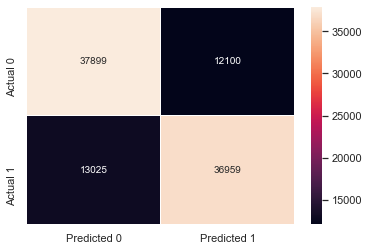

In [17]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(lstm_model.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

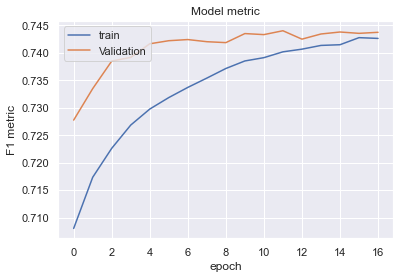

In [18]:
plt.plot(lstm_model_h1.history['f1_m'][1:])
plt.plot(lstm_model_h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

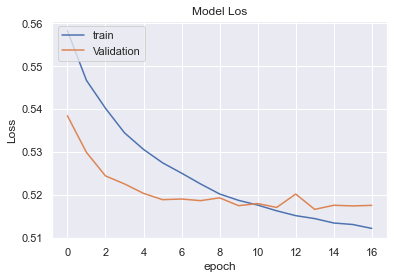

In [19]:
plt.plot(lstm_model_h1.history['loss'][1:])
plt.plot(lstm_model_h1.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()